In [6]:
import pathlib
import random
import shutil
import sys
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch
import ultralytics
import yaml
from IPython import display
from PIL import Image
from tqdm.notebook import tqdm
from ultralytics import YOLO

In [7]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", plt.matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", Image.__version__)
print("PyYAML version:", yaml.__version__)
print("torch version:", torch.__version__)
print("ultralytics version:", ultralytics.__version__)

Platform: win32
Python version: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
---
matplotlib version: 3.10.3
pandas version: 2.3.1
PIL version: 11.3.0
PyYAML version: 6.0.2
torch version: 2.7.1+cpu
ultralytics version: 8.3.195


In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")

Using cpu device.


In [9]:
!tree data_images /F /A


Folder PATH listing for volume New Volume
Volume serial number is 000000B5 CECF:0B90
D:\PROJECTS\TRAFFIC MONITORING IN DHAKA USING DEEP LEARNING\DATA_IMAGES
Invalid path - \PROJECTS\TRAFFIC MONITORING IN DHAKA USING DEEP LEARNING\DATA_IMAGES
No subfolders exist 



In [34]:
training_dir = Path("dataset") / "train"
images_dir = training_dir / "images"
annotations_dir = training_dir / "annotations"

print("Images     :", images_dir)
print("Annotations:", annotations_dir)

Images     : dataset\train\images
Annotations: dataset\train\annotations


In [39]:

# !head -n 25 $annotations_dir/01.xml

file_path = annotations_dir / "01.xml"

with open(file_path, "r") as f:
    for i in range(25):
        line = f.readline()
        if not line:
            break
        print(line.strip())


<annotation>
<folder>Images</folder>
<filename>02_Motijheel_280714_0005.jpg</filename>
<path>E:\Datasets\Dataset\Images\02_Motijheel_280714_0005.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>1200</width>
<height>800</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>bus</name>
<pose>Unspecified</pose>
<truncated>1</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>833</xmin>
<ymin>390</ymin>
<xmax>1087</xmax>
<ymax>800</ymax>
</bndbox>
</object>


In [40]:
classes = [
    "ambulance",
    "army vehicle",
    "auto rickshaw",
    "bicycle",
    "bus",
    "car",
    "garbagevan",
    "human hauler",
    "minibus",
    "minivan",
    "motorbike",
    "pickup",
    "policecar",
    "rickshaw",
    "scooter",
    "suv",
    "taxi",
    "three wheelers (CNG)",
    "truck",
    "van",
    "wheelbarrow",
]

In [41]:
class_mapping = {cls: idx for idx, cls in enumerate(classes)}

print(class_mapping)

{'ambulance': 0, 'army vehicle': 1, 'auto rickshaw': 2, 'bicycle': 3, 'bus': 4, 'car': 5, 'garbagevan': 6, 'human hauler': 7, 'minibus': 8, 'minivan': 9, 'motorbike': 10, 'pickup': 11, 'policecar': 12, 'rickshaw': 13, 'scooter': 14, 'suv': 15, 'taxi': 16, 'three wheelers (CNG)': 17, 'truck': 18, 'van': 19, 'wheelbarrow': 20}


In [42]:

width = 1200
height = 800
xmin = 833
ymin = 390
xmax = 1087
ymax = 800

In [43]:

x_center = (xmax + xmin) /2
y_center = (ymax - ymin) / 2

print(f"Bounding box center: ({x_center}, {y_center})")

Bounding box center: (960.0, 205.0)


In [44]:
def xml_to_yolo_bbox(bbox, width, height):
    """Convert the XML bounding box coordinates into YOLO format.

    Input:  bbox    The bounding box, defined as [xmin, ymin, xmax, ymax],
                    measured in pixels.
            width   The image width in pixels.
            height  The image height in pixels.

    Output: [x_center, y_center, bb_width, bb_height], where the bounding
            box is centered at (x_center, y_center) and is of size
            bb_width x bb_height.  All values are measured as a fraction
            of the image size."""

    xmin, ymin, xmax, ymax = bbox
    x_center = (xmax + xmin) /2
    y_center = (ymax - ymin) / 2
    bb_width = (xmax - xmin) / width
    bb_height = (ymax - ymin)/ height

    return [x_center, y_center, bb_width, bb_height]


xml_to_yolo_bbox([xmin, ymin, xmax, ymax], width, height)

[960.0, 205.0, 0.21166666666666667, 0.5125]

In [45]:
def parse_annotations(f):
    """Parse all of the objects in a given XML file to YOLO format.

    Input:  f      The path of the file to parse.

    Output: A list of objects in YOLO format.
            Each object is a list [index, x_center, y_center, width, height]."""

    objects = []

    tree = ET.parse(f)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall("object"):
        label = obj.find("name").text
        class_id = class_mapping[label]
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        yolo_bbox = xml_to_yolo_bbox([xmin, ymin, xmax, ymax], width, height)

        objects.append([class_id] + yolo_bbox)

    return objects


objects = parse_annotations(annotations_dir / "01.xml")
print("First object:", objects[0])

First object: [4, 960.0, 205.0, 0.21166666666666667, 0.5125]


In [46]:

def write_label(objects, filename):
    """Write the annotations to a file in the YOLO text format.

    Input:  objects   A list of YOLO objects, each a list of numbers.
            filename  The path to write the text file."""

    with open(filename, "w") as f:
        for obj in objects:
            # Write the object out as space-separated values
            f.write(" ".join(str(x) for x in obj))
            # Write a newline
            f.write("\n")

In [48]:
write_label(objects, "yolo_test.txt")
# !head -n 1 yolo_test.txt


In [49]:
extensions = set([f.suffix for f in list(images_dir.glob("*"))])
print(extensions)

{'.png', '.jpeg', '.JPG', '.jpg', '.PNG'}


In [50]:
def convert_image(fin, fout):
    """Open the image at `fin`, convert to a RGB JPEG, and save at `fout`."""
    Image.open(fin).convert("RGB").save(fout, "JPEG")

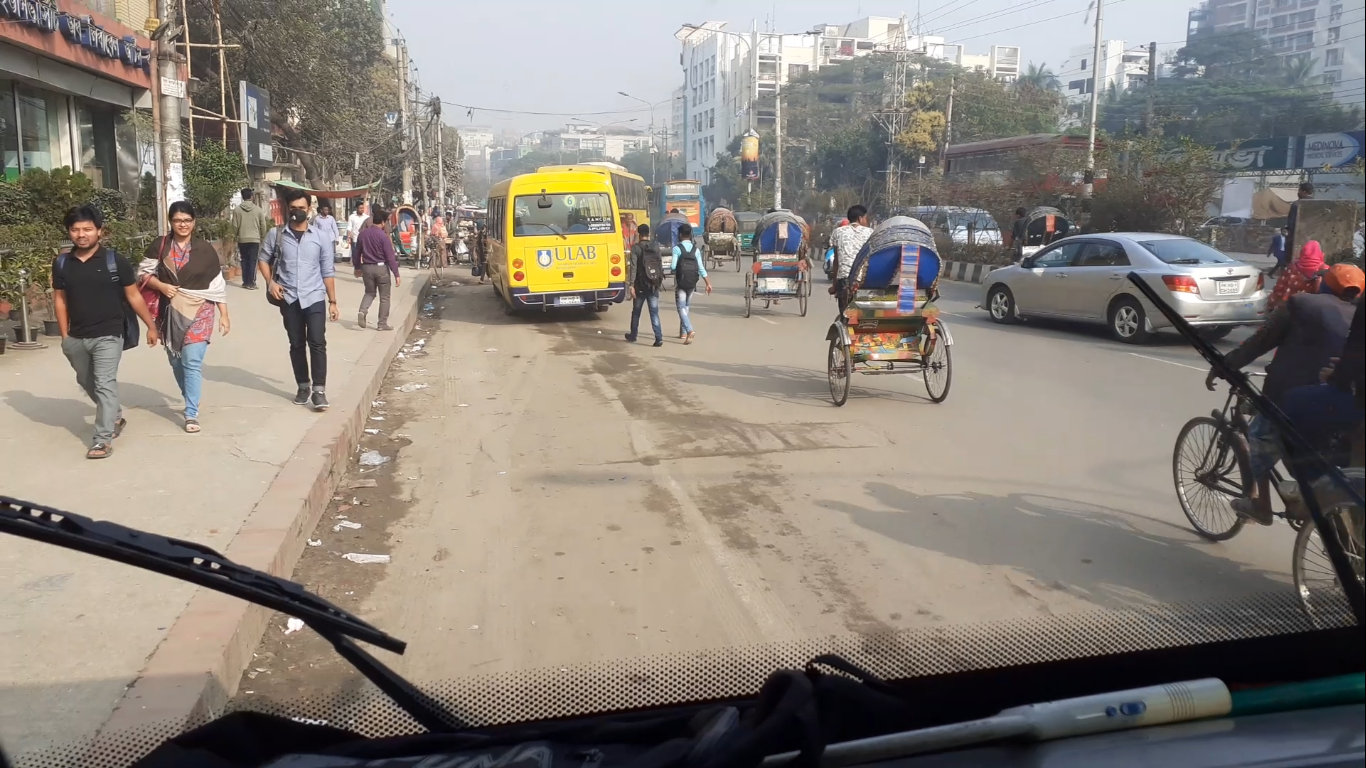

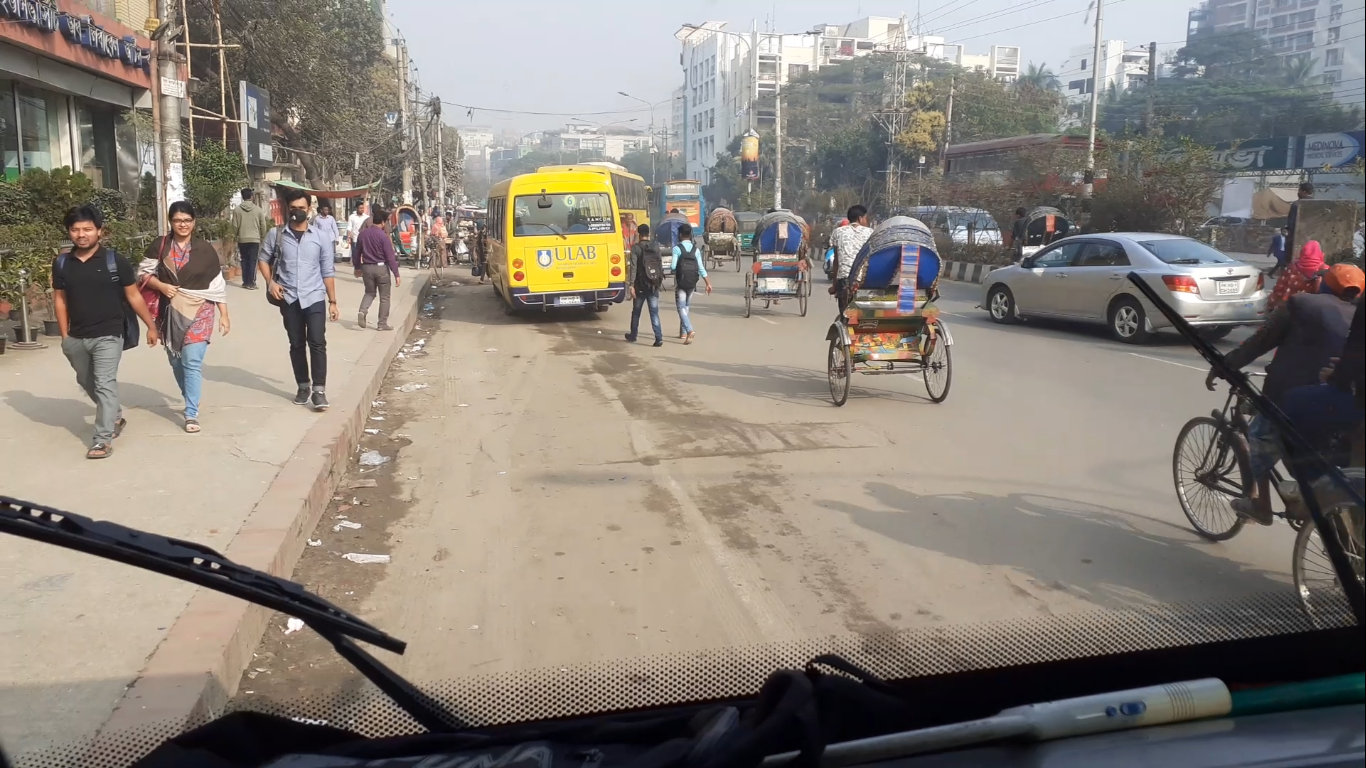

In [51]:
test_image = images_dir / "193.png"
convert_image(test_image, "test_image.jpg")

display.display(
    Image.open(images_dir / "193.png"),
    Image.open(test_image)  

)

In [52]:
yolo_base = pathlib.Path("data_yolo")

# It's important to clear out the directory, if it already
# exists.  We'll get a different train / validation split
# each time, so we need to make sure the old images are
# cleared out.
shutil.rmtree(yolo_base, ignore_errors=True)

(yolo_base / "images" / "train").mkdir(parents=True)
# Create the remaining directories.
(yolo_base / "images" / "val").mkdir(parents=True)
(yolo_base / "labels" / "train").mkdir(parents=True)
(yolo_base / "labels" / "val").mkdir(parents=True)

!tree $yolo_base

Folder PATH listing for volume New Volume
Volume serial number is 0000005B CECF:0B90
D:\PROJECTS\TRAFFIC MONITORING IN DHAKA USING DEEP LEARNING\DATA_YOLO
����images
�   ����train
�   ����val
����labels
    ����train
    ����val


In [53]:

train_frac = 0.8
images = list(images_dir.glob("*"))

for img in tqdm(images):
    split = "train" if random.random() < train_frac else "val"

    annotation = annotations_dir / f"{img.stem}.xml"
    # This might raise an error:
    try:
        parsed = parse_annotations(annotation)
    except Exception as e:
        print(f'Failed to pass "{img.stem}".Skipping')
    
    dest = yolo_base / "labels" / split / f"{img.stem}.txt"
    write_label(parsed, dest)

    dest = yolo_base / "images" / split / f"{img.stem}.jpg"
    convert_image(img, dest)

  0%|          | 0/3003 [00:00<?, ?it/s]

Failed to pass "231".Skipping
Failed to pass "Pias (359)".Skipping
Failed to pass "Pias (360)".Skipping


In [56]:

train_count = len(list((yolo_base / "images" / "train").glob("*")))
val_count = len(list((yolo_base / "images" / "val").glob("*")))
total_count = train_count + val_count

print(f"Training fraction:   {train_count/total_count:0.3f}")
print(f"Validation fraction: {val_count/total_count:0.3f}")

Training fraction:   0.813
Validation fraction: 0.187


In [57]:

metadata = {
    "path": str(
        yolo_base.absolute()
    ),  # It's easier to specify absolute paths with YOLO.
    
    "train": "images/train", # Training images, relative to above.
    
    "val": "images/val", # Validation images
    
    "names": classes, # Class names, as a list
    
    "nc": len(classes), # Number of classes
}

print(metadata)

{'path': 'd:\\Projects\\Traffic Monitoring in Dhaka using Deep learning\\data_yolo', 'train': 'images/train', 'val': 'images/val', 'names': ['ambulance', 'army vehicle', 'auto rickshaw', 'bicycle', 'bus', 'car', 'garbagevan', 'human hauler', 'minibus', 'minivan', 'motorbike', 'pickup', 'policecar', 'rickshaw', 'scooter', 'suv', 'taxi', 'three wheelers (CNG)', 'truck', 'van', 'wheelbarrow'], 'nc': 21}


In [58]:
yolo_config = "data.yaml"
# Using yaml.safe_dump() protects you from some oddities in the YAML format.
# It takes the same arguments as json.dump().
yaml.safe_dump(metadata, open(yolo_config, 'w'))


!type data.yaml

names:
- ambulance
- army vehicle
- auto rickshaw
- bicycle
- bus
- car
- garbagevan
- human hauler
- minibus
- minivan
- motorbike
- pickup
- policecar
- rickshaw
- scooter
- suv
- taxi
- three wheelers (CNG)
- truck
- van
- wheelbarrow
nc: 21
path: d:\Projects\Traffic Monitoring in Dhaka using Deep learning\data_yolo
train: images/train
val: images/val


In [ ]:
model = YOLO("yolov8n.pt")  # start from pretrained weights


In [66]:
model = YOLO("runs/detect/train/weights/last.pt")


In [67]:
save_dir = Path("runs/detect/train/weights/")

In [68]:

print(save_dir)

runs\detect\train\weights


In [69]:

!tree $save_dir

Folder PATH listing for volume New Volume
Volume serial number is 00000015 CECF:0B90
D:\PROJECTS\TRAFFIC MONITORING IN DHAKA USING DEEP LEARNING\RUNS\DETECT\TRAIN\WEIGHTS
No subfolders exist 



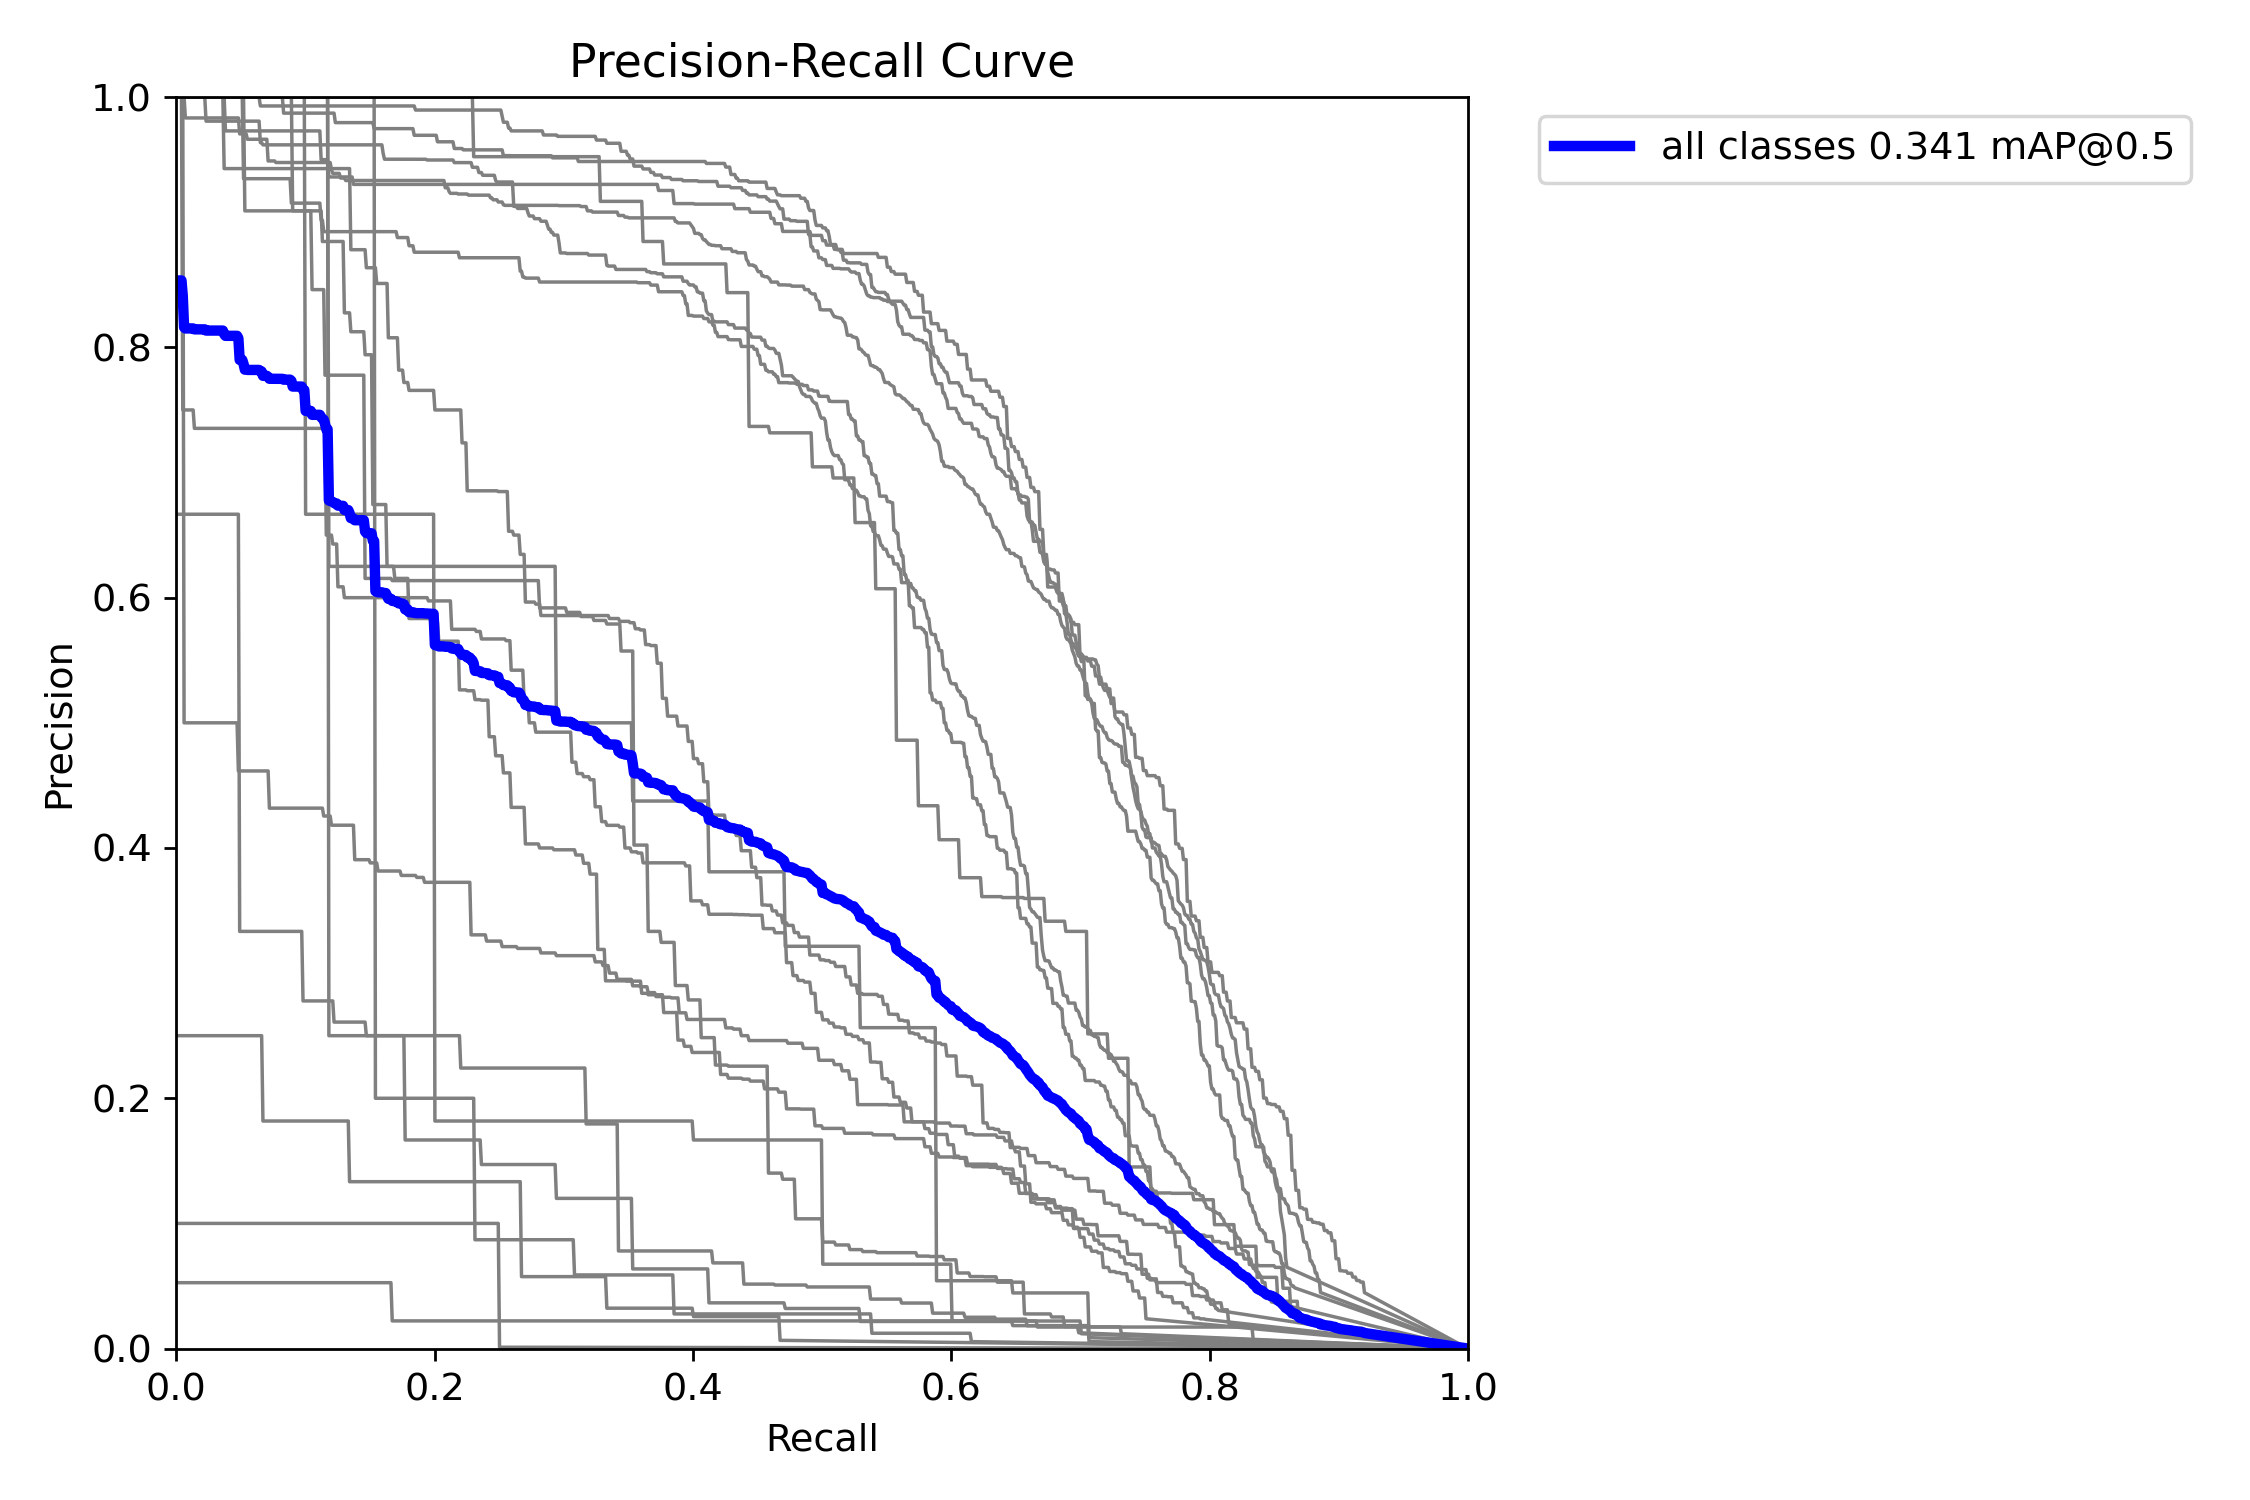

In [71]:
Image.open(save_dir / "PR_curve.png")

In [72]:
!type data.yaml



names:
- ambulance
- army vehicle
- auto rickshaw
- bicycle
- bus
- car
- garbagevan
- human hauler
- minibus
- minivan
- motorbike
- pickup
- policecar
- rickshaw
- scooter
- suv
- taxi
- three wheelers (CNG)
- truck
- van
- wheelbarrow
nc: 21
path: d:\Projects\Traffic Monitoring in Dhaka using Deep learning\data_yolo
train: images/train
val: images/val


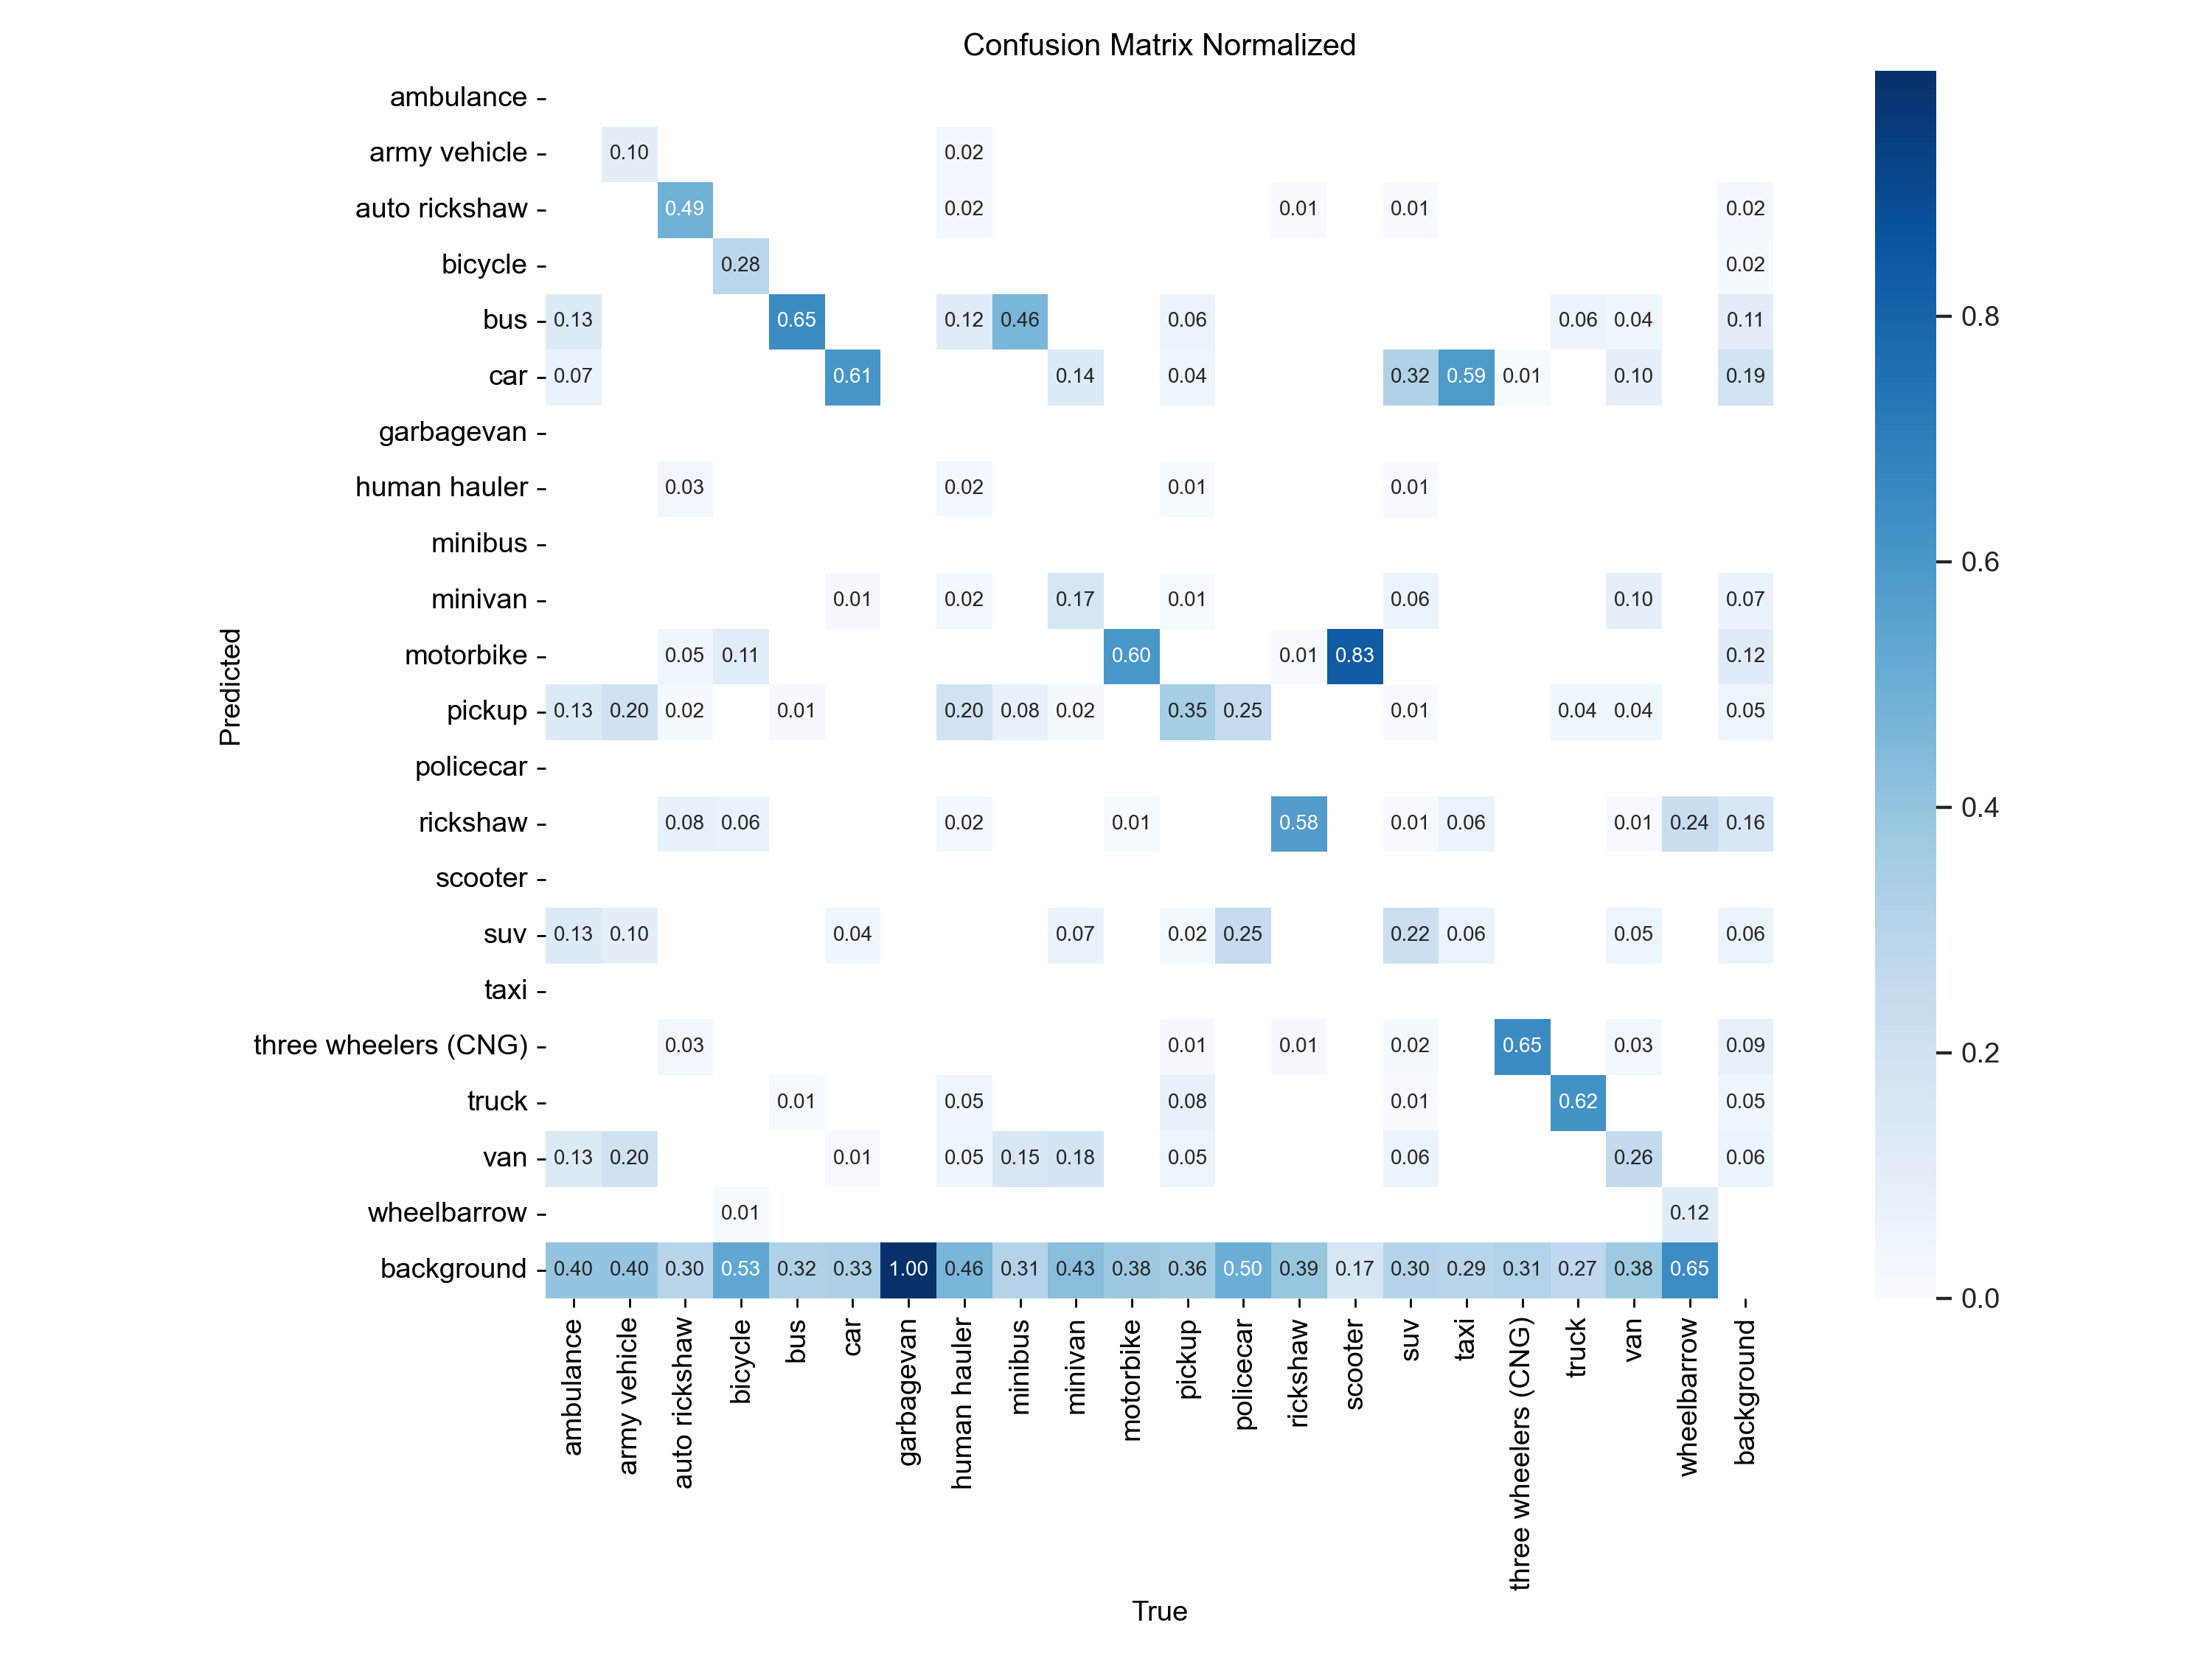

In [73]:
Image.open(save_dir / "confusion_matrix_normalized.png")

In [74]:
df = pd.read_csv(save_dir / "results.csv", skipinitialspace=True).set_index(
    "epoch"
)
df.head()

time  train/box_loss  train/cls_loss  train/dfl_loss  \
epoch                                                             
1       35.1072         1.45223         3.32406         1.16199   
2       67.5593         1.42356         2.24330         1.17132   
3       99.9395         1.38437         2.04035         1.16109   
4      131.5240         1.36695         1.91453         1.15004   
5      163.3040         1.32782         1.81436         1.12958   

       metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
epoch                                                              
1                   0.59554            0.11979           0.10365   
2                   0.67236            0.15496           0.13611   
3                   0.56155            0.18055           0.16316   
4                   0.60072            0.19290           0.17265   
5                   0.55458            0.21755           0.19436   

       metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss  \
epoch                                                                  
1                  0.06298       1.36083       2.15096       1.11174   
2                  0.08650       1.33130       1.89784       1.10711   
3                  0.10168       1.30970       1.70307       1.10191   
4                  0.10846       1.28410       1.66555       1.08647   
5                  0.12272       1.25971       1.53956       1.07159   

         lr/pg0    lr/pg1    lr/pg2  
epoch                                
1      0.000133  0.000133  0.000133  
2      0.000257  0.000257  0.000257  
3      0.000373  0.000373  0.000373  
4      0.000360  0.000360  0.000360  
5      0.000347  0.000347  0.000347

In [75]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


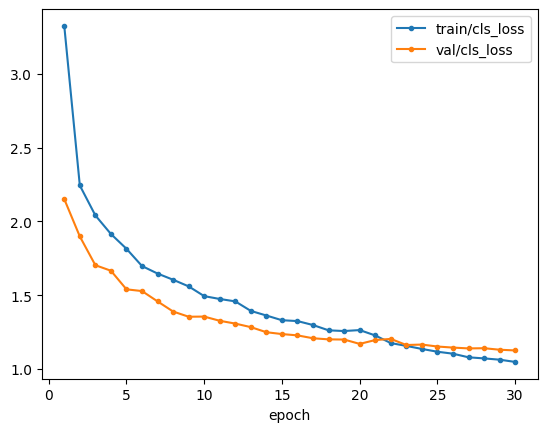

In [78]:
#  The `.plot` method on DataFrames may be useful.
df[['train/cls_loss', 'val/cls_loss']].plot(marker='.');